<a href="https://colab.research.google.com/github/WonJunPark/Kaggle_DFDC/blob/master/image_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library import

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
work_root_path = '/content/gdrive/My Drive/Kaggle/DFDC/'

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm,trange
from sklearn.model_selection import train_test_split
import sklearn.metrics

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

In [0]:
import random

def read_img(path):
    return cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)

def shuffle(X,y):
    new_train=[]
    for m,n in zip(X,y):
        new_train.append([m,n])
    random.shuffle(new_train)
    X,y=[],[]
    for x in new_train:
        X.append(x[0])
        y.append(x[1])
    return X,y

# Data loads

In [0]:
real = os.listdir('/content/gdrive/My Drive/Kaggle/DFDC/dfdc_train_v1/real')
fake = os.listdir('/content/gdrive/My Drive/Kaggle/DFDC/dfdc_train_v1/fake')

In [36]:
X,y=[],[]

for file in tqdm(real):
  try :
    im = read_img(f'/content/gdrive/My Drive/Kaggle/DFDC/dfdc_train_v1/real/{file}')
    im = cv2.resize(im, (150,150))
    X.append(im)
    y.append(0)
  except :
    print(im)

 93%|█████████▎| 8044/8604 [00:44<00:03, 175.19it/s]

[[[160 112  76]
  [163 113  78]
  [166 116  81]
  ...
  [ 72  55  47]
  [ 72  55  47]
  [ 72  55  47]]

 [[158 109  73]
  [161 111  75]
  [166 115  79]
  ...
  [ 72  55  47]
  [ 72  55  47]
  [ 72  55  47]]

 [[158 108  72]
  [162 112  75]
  [166 116  79]
  ...
  [ 72  55  47]
  [ 72  55  47]
  [ 72  55  47]]

 ...

 [[ 91  54  40]
  [ 91  55  41]
  [ 91  55  41]
  ...
  [123  92  72]
  [123  92  72]
  [123  92  72]]

 [[ 92  56  42]
  [ 94  58  44]
  [ 94  58  44]
  ...
  [123  92  72]
  [123  92  72]
  [123  92  72]]

 [[ 94  58  44]
  [ 95  59  45]
  [ 96  60  46]
  ...
  [124  93  73]
  [124  93  73]
  [124  93  73]]]


100%|██████████| 8604/8604 [00:47<00:00, 181.68it/s]


In [37]:
test_X, test_y = [],[]

for file in tqdm(fake):
    try :
      im = read_img(f'/content/gdrive/My Drive/Kaggle/DFDC/dfdc_train_v1/fake/{file}')
      im = cv2.resize(im, (150,150))
      X.append(im)
      y.append(1)
      test_X.append(im)
      test_y.append(1)
    except :
      print(im)

 96%|█████████▋| 12028/12471 [01:19<00:03, 143.54it/s]

[[[203 171 158]
  [198 163 153]
  [189 151 143]
  ...
  [ 36  17  13]
  [ 36  18  14]
  [ 37  19  15]]

 [[199 168 157]
  [194 162 151]
  [190 155 145]
  ...
  [ 35  17  14]
  [ 38  20  16]
  [ 39  21  17]]

 [[195 166 155]
  [190 161 150]
  [188 156 146]
  ...
  [ 36  18  14]
  [ 39  21  17]
  [ 41  23  19]]

 ...

 [[175 155 147]
  [170 150 140]
  [162 143 133]
  ...
  [ 98  60  47]
  [ 99  61  48]
  [101  63  50]]

 [[152 138 129]
  [146 130 121]
  [135 118 108]
  ...
  [ 97  59  46]
  [ 96  59  46]
  [ 99  61  48]]

 [[123 109 100]
  [119 102  94]
  [108  90  83]
  ...
  [ 95  59  45]
  [ 95  59  45]
  [ 96  60  46]]]


100%|██████████| 12471/12471 [01:22<00:00, 151.43it/s]


In [0]:
X, y = shuffle(X,y)

In [40]:
print(len(X))
print(len(y))

21073
21073


In [0]:
train_X = X[:int(len(X)*0.8)]
train_y = y[:int(len(y)*0.8)]

In [45]:
print( len(train_X), len(train_y) )

16858 16858


In [0]:
val_X = X[int(len(X)*0.8):]
val_y = y[int(len(y)*0.8):]

In [47]:
print( len(val_X), len(val_y) )

4215 4215


In [0]:
from torch.utils.data import Dataset, DataLoader
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

class ImageDataset(Dataset):
    def __init__(self, X, y, training=True, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.training = training

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img = self.X[idx]

        if self.transform is not None:
          res = self.transform(image=img)
          img = res['image']
        
        img = np.rollaxis(img, 2, 0)
        # img = np.array(img).astype(np.float32) / 255.

        labels = self.y[idx]
        labels = np.array(labels).astype(np.float32)
        return [img, labels]

# Model

In [49]:
!pip install pytorchcv --quiet
from pytorchcv.model_provider import get_model
model = get_model("xception", pretrained=True)
# model = get_model("resnet18", pretrained=True)
model = nn.Sequential(*list(model.children())[:-1]) # Remove original output layer

     |████████████████████████████████| 399kB 2.8MB/s 


In [0]:
model[0].final_block.pool = nn.Sequential(nn.AdaptiveAvgPool2d(1))
# model[0].final_pool = nn.Sequential(nn.AdaptiveAvgPool2d(1))

In [0]:
class Head(torch.nn.Module):
  def __init__(self, in_f, out_f):
    super(Head, self).__init__()
    
    self.f = nn.Flatten()
    self.l = nn.Linear(in_f, 512)
    self.d = nn.Dropout(0.75)
    self.o = nn.Linear(512, out_f)
    self.b1 = nn.BatchNorm1d(in_f)
    self.b2 = nn.BatchNorm1d(512)
    self.r = nn.ReLU()

  def forward(self, x):
    x = self.f(x)
    x = self.b1(x)
    x = self.d(x)

    x = self.l(x)
    x = self.r(x)
    x = self.b2(x)
    x = self.d(x)

    out = self.o(x)
    return out

In [0]:
class FCN(torch.nn.Module):
  def __init__(self, base, in_f):
    super(FCN, self).__init__()
    self.base = base
    self.h1 = Head(in_f, 1)
  
  def forward(self, x):
    x = self.base(x)
    return self.h1(x)

model = FCN(model, 2048)

# Train Functions

In [0]:
def criterion1(pred1, targets):
  l1 = F.binary_cross_entropy(F.sigmoid(pred1), targets)
  return l1

def train_model(epoch, optimizer, scheduler=None, history=None):
    model.train()
    total_loss = 0
    
    t = tqdm(train_loader)
    for i, (img_batch, y_batch) in enumerate(t):
        img_batch = img_batch.cuda().float()
        y_batch = y_batch.cuda().float()

        optimizer.zero_grad()

        out = model(img_batch)
        loss = criterion1(out, y_batch)

        total_loss += loss
        t.set_description(f'Epoch {epoch+1}/{n_epochs}, LR: %6f, Loss: %.4f'%(optimizer.state_dict()['param_groups'][0]['lr'],total_loss/(i+1)))

        if history is not None:
          history.loc[epoch + i / len(X), 'train_loss'] = loss.data.cpu().numpy()
          history.loc[epoch + i / len(X), 'lr'] = optimizer.state_dict()['param_groups'][0]['lr']

        loss.backward()
        optimizer.step()
        if scheduler is not None:
          scheduler.step()

def evaluate_model(epoch, scheduler=None, history=None):
    model.eval()
    loss = 0
    pred = []
    real = []
    with torch.no_grad():
        for img_batch, y_batch in val_loader:
            img_batch = img_batch.cuda().float()
            y_batch = y_batch.cuda().float()

            o1 = model(img_batch)
            l1 = criterion1(o1, y_batch)
            loss += l1
            
            for j in o1:
              pred.append(F.sigmoid(j))
            for i in y_batch:
              real.append(i.data.cpu())
    
    pred = [p.data.cpu().numpy() for p in pred]
    pred2 = pred
    pred = [np.round(p) for p in pred]
    pred = np.array(pred)
    acc = sklearn.metrics.recall_score(real, pred, average='macro')

    real = [r.item() for r in real]
    pred2 = np.array(pred2).clip(0.1, 0.9)
    kaggle = sklearn.metrics.log_loss(real, pred2)

    loss /= len(val_loader)
    
    if history is not None:
        history.loc[epoch, 'dev_loss'] = loss.cpu().numpy()
    
    if scheduler is not None:
      scheduler.step(loss)

    print(f'Dev loss: %.4f, Acc: %.6f, Kaggle: %.6f'%(loss,acc,kaggle))
    
    return loss

In [0]:
import albumentations
from albumentations.augmentations.transforms import ShiftScaleRotate, HorizontalFlip, Normalize, RandomBrightnessContrast, MotionBlur, Blur, GaussNoise, JpegCompression
train_transform = albumentations.Compose([
                                          ShiftScaleRotate(p=0.3, scale_limit=0.25, border_mode=1, rotate_limit=25),
                                          HorizontalFlip(p=0.2),
                                          RandomBrightnessContrast(p=0.3, brightness_limit=0.25, contrast_limit=0.5),
                                          MotionBlur(p=.2),
                                          GaussNoise(p=.2),
                                          JpegCompression(p=.2, quality_lower=50),
                                          Normalize()
])
val_transform = albumentations.Compose([
                                          Normalize()
])

train_dataset = ImageDataset(train_X, train_y, transform=train_transform)
val_dataset = ImageDataset(val_X, val_y, transform=val_transform)

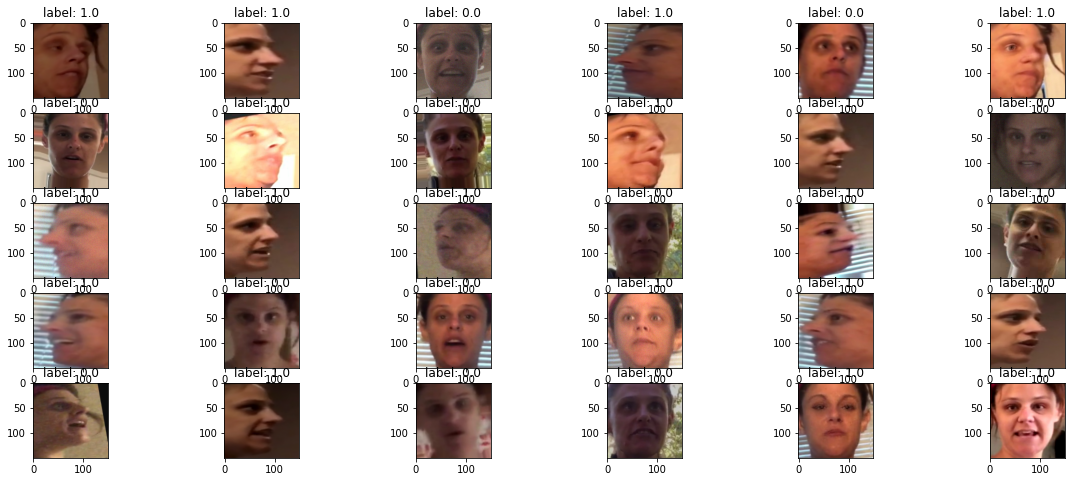

In [55]:
nrow, ncol = 5, 6
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in enumerate(axes):
    image, label = train_dataset[i]
    image = np.rollaxis(image, 0, 3)
    image = image*std + mean
    image = np.clip(image, 0., 1.)
    ax.imshow(image)
    ax.set_title(f'label: {label}')

In [56]:
import gc

history = pd.DataFrame()
history2 = pd.DataFrame()

torch.cuda.empty_cache()
gc.collect()

best = 1e10
n_epochs = 20
batch_size = 128

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

model = model.cuda()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, mode='min', factor=0.7, verbose=True, min_lr=1e-5)

for epoch in range(n_epochs):
    torch.cuda.empty_cache()
    gc.collect()

    train_model(epoch, optimizer, scheduler=None, history=history)
    
    loss = evaluate_model(epoch, scheduler=scheduler, history=history2)
    
    if loss < best:
      best = loss
      print(f'Saving best model...')
      torch.save(model.state_dict(), f'model.pth')

RuntimeError: ignored